In [ ]:
# Conducting experiments on the sharpness of the bound on the injectivity radius of the Stiefel manifold St(4,2)

In [3]:
#!pip install import-ipynb

import scipy
import numpy as np
from numpy import random

import matplotlib.pyplot as plt

import sys

import pickle

import pprint

import import_ipynb

import Stiefel_Exp_Log                as StEL
import Stiefel_Aux        as StAux

In [16]:
#functions

def get_ordn(x):
    #get z for distpi := x \in O(10^-z) for distpi < 1
    
    if x < 1:
        i=0
        while x < 1:
            x = x*10
            i-=1
        return i
    else:
        i=-1
        while x > 1:
            x = x/10
            i+=1
        return i

def calc_next_logs(origV,mu,p): 
    # calculate norm(C(log(origV*[[np.cos(mu[k]),-np.sin(mu[k])],[np.sin(mu[k]),np.cos(mu[k])]])))
    # for all phases in mu
    
    conv_mu = np.ones(len(mu))
    V = np.copy(origV)
    
    for k in range(len(mu)):
        Phi = np.array([[np.cos(mu[k]),-np.sin(mu[k])],[np.sin(mu[k]),np.cos(mu[k])]])
        V[:,p:2*p] = np.dot(origV[:,p:2*p],Phi)   # update last p columns
        
        [LV, flag_negval] = StAux.SchurLog(V,0)
                                  # standard matrix logarithm
                                  #             |Ak  -Bk'|
                                  # now, LV =   |Bk   Ck |
        # some safety measures:
        # ensure that LV is skew
        LV = 0.5*(LV-LV.T)
        
        C = LV[p:2*p, p:2*p]      # lower (pxp)-diagonal block
 
        conv_mu[k] = np.linalg.norm(C, 'fro')
    
    return conv_mu

def go_into_locMin(origV, mu, conv_mu, tau, p, max_depth = 10, pis = 200):
    #get all local minima (recursively defined)
    #
    # Input:
    # origV: original initial matrix which gets multipied by the block-diagonal matrix [I,Phi]
    # mu: list of phases defining the rotation-matrix Phi
    # conv_mu: list of norms of the C-block of the logarithm of origV multiplied by the diag([I,Phi]) defined by the list mu
    # tau: numerical threshold for considering the C-block of the logarithm of origV multiplied by a certain diag([I,Phi]) to be zero
    # p: dimension of St(n,p)
    # max_depth: limits the recursion depth of this function
    # pis: defines the fineness of the new intervals in which local minima are searched for
    #
    # Output:
    # mins: list of phases which are defining Phi such that the lower right block of log_m(origV*diag([I,Phi])) is zero
    
    #get indizes of the local minima of conv_mu
    ind_locmin = scipy.signal.argrelextrema(conv_mu,np.less)[0]
    mins = list([])
    
    #no local minima found
    if len(ind_locmin) == 0:
        return list([])
    
    for i in range(len(ind_locmin)):
        locmin = ind_locmin[i]
        
        #a connecting tangent vector is found
        if conv_mu[locmin] < tau:
            mins.append(mu[locmin])
        
        else:
            if max_depth > 0:
            
                #refine interval
                new_mu = np.linspace(mu[int(max(0,locmin-1))],mu[int(min(len(mu)-1,locmin+1))],pis)
                new_conv_mu = calc_next_logs(origV,new_mu, p)
        
                #continue only with improvement
                o = get_ordn(conv_mu[locmin])
                if max(conv_mu[locmin] - new_conv_mu) > 10**(o-1):
                    new_depth = max_depth-1
                    val = go_into_locMin(origV, new_mu, new_conv_mu, tau, p, max_depth = new_depth)
                    for x in val:
                        mins.append(x)
    return mins


def Stiefel_Log_p2(U0, U1, tau, pis): 
    #calculating all tangent vectors connecting U0 and U1
    
    # get dimensions
    n,p = U0.shape
    
    M = np.dot(U0.T, U1)
    U0orth = U1 - np.dot(U0,M)
    # thin qr of normal component of U1
    Q, N = scipy.linalg.qr(U0orth, overwrite_a=True,\
                                lwork=None,\
                                mode='economic',\
                                pivoting=False,\
                                check_finite=True)
    
    MN = np.concatenate((M,N), axis=0)
    # orthogonal completion
    V, R = scipy.linalg.qr(MN,overwrite_a=True,\
                               lwork=None,\
                               mode='full',\
                               pivoting=False,\
                               check_finite=True)
        
    V = np.concatenate((MN, V[:,p:2*p]), axis=1)
                                           #          |M  X0|
                                           # now, V = |N  Y0|
    
    #check whether V is in SO(2p) with the knowledge, that qr is using Householder-Trafos
    if np.power(-1,p)*np.prod(np.diag(R[:p,:p])) < 0:
        # flip sign of one column
        V[:,p] = (-1)*V[:,p]
       
    mu = np.linspace(0.0,2*np.pi,pis)
    origV = np.copy(V)
    
    conv_mu = calc_next_logs(origV,mu,p)
    
    #look for rotations corresponding such that C(log_m(V*diag([I,Phi]))) = 0 
    alphas = go_into_locMin(origV, mu, conv_mu, tau, p)
  
    # prepare output                         |A  -B'|
    # upon convergence, we have  logm(V) =   |B   0 | = LV
    #     A = LV(1:p,1:p);     B = LV(p+1:2*p, 1:p)
    # Delta = U0*A+Q*B
    Deltas = list([])
    for alpha in alphas:
        Phi = np.array([[np.cos(alpha),-np.sin(alpha)],[np.sin(alpha),np.cos(alpha)]])
        V[:,p:2*p] = np.dot(origV[:,p:2*p],Phi)
        [LV, flag_negval] = StAux.SchurLog(V)
        LV = 0.5*(LV-LV.T)
        Delta = np.dot(U0,LV[0:p,0:p]) + np.dot(Q, LV[p:2*p, 0:p])
        Deltas.append(Delta)
        
    return Deltas

In [17]:
#Initialize
mu_ns = {}

#number of runs for each St(n,2)
rep = 250

#defines the fineness of the intervals in which local minima are searched for
pis = 200

p = 2

tau = 1.0e-12

In [47]:
#Conducting experiments

for n in range(4,51):#51
    print(f"######{n}######")
    mu = 3.2
    i=0
    for i in range(rep):
        if (i+1)%10 == 0:
            print(i+1)
        #random starting point
        X =  random.rand(n,p)
        U0, R = scipy.linalg.qr(X, overwrite_a=True,\
                                    lwork=None,\
                                    mode='economic',\
                                    pivoting=False,\
                                    check_finite=True)
    
        #get random U in distance mu along a geodesic from U0 defined by a random tangent vector Delta
        A = random.rand(p,p)
        A = A-A.transpose()   # "random" p-by-p skew symmetric matrix
        T = random.rand(n,p)
        Delta = np.dot(U0,A)+ T-np.dot(U0,np.dot(U0.transpose(),T))
        #normalize Delta w.r.t. the canonical metric
        norm_Delta = np.sqrt(StAux.alphaMetric(Delta, Delta, U0,0.0))
        Delta = (1/norm_Delta)*Delta
        Delt = mu*Delta
        U = StEL.Stiefel_Exp(U0,Delt)
        
        #get all tangent vectors connecting U0 and U
        Deltas = Stiefel_Log_p2(U0,U,tau,pis)

        for D in Deltas:
            U1 = StEL.Stiefel_Exp(U0,D)
            if np.linalg.norm(U-U1) < 1.0e-12:
                #D is tangentvector connecting U0 and U
                if np.sqrt(StAux.alphaMetric(D, D, U0,0.0)) <= mu:
                    #D is shorter or of equal length as Delt
                    if np.linalg.norm(D-Delt) > 1.0e-8:
                        #D is not Delt
                        mu_ns[n] = mu
                        if mu < 2.91:
                            print(mu)
                        mu -= 0.01

######4######
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
2.900000000000002
190
200
2.8900000000000023
210
220
230
240
250
######5######
10
20
30
40
50
60
70
80
90
100
110
120
130
140
2.900000000000002
150
160
170
180
2.8900000000000023
190
200
210
220
2.8800000000000026
230
240
250
######6######
10
20
30
40
50
60
2.900000000000002
2.8900000000000023
70
2.8800000000000026
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
######7######
10
20
30
40
2.900000000000002
50
60
2.8900000000000023
70
80
90
2.8800000000000026
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
######8######
10
20
2.900000000000002
30
40
50
60
70
2.8900000000000023
2.8800000000000026
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
######9######
10
20
2.900000000000002
30
2.8900000000000023
2.8800000000000026
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
######10######
10
20
30
2.900000000000002
2.890000000

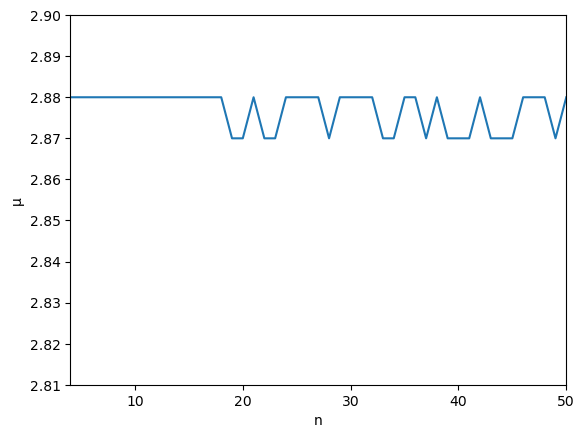

In [63]:
#plot smallest distance of points to which a shorter geodesic existed

myList = mu_ns.items()
myList = sorted(myList) 
x, y = zip(*myList) 

plt.xlim(4,50)
plt.ylim(2.81,2.9)
plt.xlabel("n")
plt.ylabel('μ')
plt.plot(x, y)
plt.show()

In [61]:
mu_ns = pickle.load(open("St42_from32run250_plotable.pkl","rb"))

In [60]:
pickle.dump(mu_ns1,open("St42_from32run250_plotable.pkl","wb"))